# Courses recommendations

Courses recommendations from Emagister <span style="color:red">Explicación modelo de negocio</span>

## Table of contents

* I. Exploratory Data Analysis
* II. Rank Based Recommendations
* III. Neighborhood Based Collaborative Filtering
* IV. Content Based Recommendations
* V. Model Based Collaborative Filtering
* VI. Extras & Concluding

## Import libraries

In [144]:
import numpy as np
import pandas as pd
from db_utils import connection
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


## Load Data

### Loading leads

In [ ]:
leads_query = 'SELECT * FROM clean_leads ORDER BY created_on DESC'

leads_df = pd.read_sql_query(leads_query, con=connection())

### Loading reviews

In [ ]:
reviews_query = 'SELECT * FROM clean_reviews ORDER BY created_on DESC'

reviews_df = pd.read_sql_query(reviews_query, con=connection())

### Loading courses

In [ ]:
courses_query = '''SELECT c.*, cat.name AS category_name FROM courses c 
                    JOIN categories cat ON c.category_id = cat.id'''

courses_df = pd.read_sql_query(courses_query, con=connection())

## I. Exploratory Data Analysis
### Top courses by number of leads generated

In [145]:
top_courses = courses_df.sort_values('number_of_leads', ascending=False).head(10)

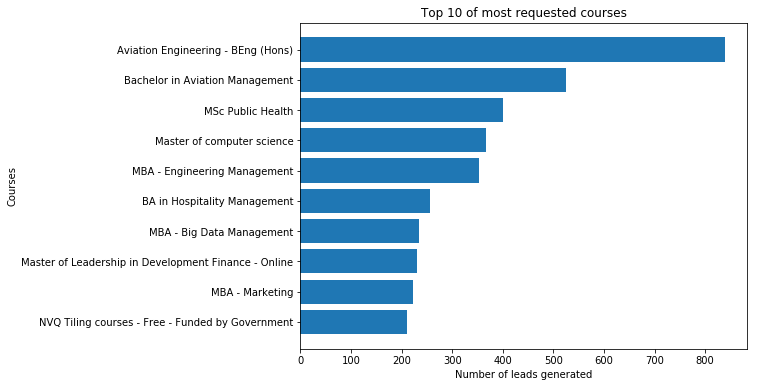

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_courses['title'], top_courses['number_of_leads'])
ax.set_title('Top 10 of most requested courses')
ax.set_xlabel('Number of leads generated')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

### Top categories by number of leads generated

In [ ]:
top_categories = courses_df.groupby('category_name').count().sort_values('number_of_leads', ascending=False)['number_of_leads'].head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_categories.index, top_categories.values)
ax.set_title('Top 10 most requested categories')
ax.set_xlabel('Number of leads generated')
ax.set_ylabel('Categories')
ax.invert_yaxis()
plt.show();

### Number of users that generates an amount of leads

In [147]:
counts = leads_df.groupby('user_id')['course_id'].count().values

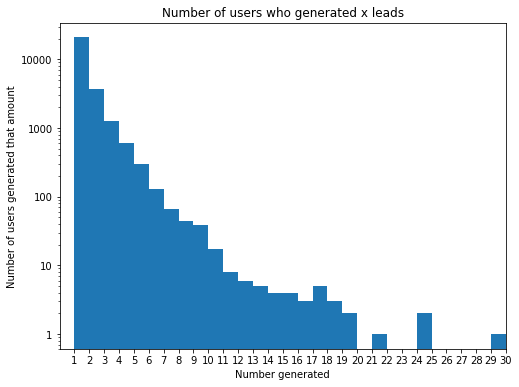

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(min(counts), max(counts) + 1)
plt.hist(counts, bins=bins)
ax.set_title('Number of users who generated x leads')
ax.set_xlabel('Number generated')
ax.set_ylabel('Number of users generated that amount')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlim(0, max(counts))
plt.xticks(np.arange(min(counts), max(counts) + 1, 1.0))

plt.show();

The trend is that each user generates few leads. We note that most users only generate a lead

### The most reviewed courses

In [ ]:
top_reviewed_courses = courses_df.groupby('title').sum().sort_values('num_reviews', ascending=False).head(10)['num_reviews']

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_reviewed_courses.index, top_reviewed_courses.values)
ax.set_title('Top 10 courses by number of reviews')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

courses_wr = courses_df[~courses_df['weighted_rating'].isnull()]['weighted_rating']
ax.hist(courses_wr)
ax.set_title('Weighted Rating Distribution')
ax.set_xlabel('Weighted Rating')
ax.set_ylabel('Number of Courses')

plt.show();

## II. Rank Based Recommendations

In this case there will be two rankings to create recommendations: a ranking of the most requested courses and a ranking of the most valued courses.

### The most popular courses

In [143]:
def get_top_courses_by_leads(df, n=10, category=None, titles=False):
    """ 
    Creates an array of n courses ordered by number of leads generated
    
    :param df DataFrame: Leads dataframe
    :param n int: Number of courses in the array
    :param category str: If category is supplied, the array will be of courses belonging to that category
    :param titles bool: If titles is True, the array will be of course names, 
        if False the array will be of course ids
    :return numpy.ndarray: Array of top n courses by leads generated
    """
    column = 'id'
    
    if titles:
        column = 'title'
        
    if category:
        df = df[df['category_name'] == category]
        
    top_courses = df.sort_values('number_of_leads', ascending=False)[column].head(n)
    
    return top_courses.values

In [ ]:
print(get_top_courses_by_leads(courses_df, category='Engineering', titles=True))

https://baymard.com/blog/sort-by-customer-ratings

https://stackoverflow.com/questions/1411199/what-is-a-better-way-to-sort-by-a-5-star-rating

### The most valued courses

In [ ]:
def get_top_courses_by_rating(df, n=10, category=None, titles=False):
    """ 
    Creates an array of n courses ordered by rating
    
    :param df DataFrame: Reviews dataframe
    :param n int: Number of courses in the array
    :param category str: If category is supplied, the array will be of courses belonging to that category
    :param titles bool: If titles is True, the array will be of course names.
                        If False the array will be of course ids
                          
    :return numpy.ndarray: Array of top n courses by rating
    """
    return_column = 'id'
    sort_column = 'weighted_rating'
    
    if titles:
        return_column = 'title'
        
    if category:
        df = df[df['category_name'] == category]
    
    top_courses = df.sort_values(by=sort_column, ascending=False)
    
    return top_courses[return_column].values[:n]

In [ ]:
get_top_courses_by_rating(courses_df, category='Engineering', titles=True)

## III. Neighborhood Based Collaborative Filtering

### User-item matrix
Loading the user-item matrices

In [ ]:
ratings_user_item_matrix = pd.read_csv('../data/ratings_matrix.csv')
leads_user_item_matrix = pd.read_csv('../data/leads_matrix.csv')

In [ ]:
ratings_user_item_matrix.set_index('user_id', inplace=True)
leads_user_item_matrix.set_index('user_id', inplace=True)

### User-courses interactions

Loading the user-course interactions dictionaries.

In [ ]:
with open('../data/rated_courses.pickle', 'rb') as file:
    rated_courses = pickle.load(file)

with open('../data/generated_leads.pickle', 'rb') as file:
    generated_leads = pickle.load(file)

In [142]:
np.dot(np.array([0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 0]))

0

### Recommendations based on leads generated

In [140]:
def find_similar_users(user_id, user_item_matrix, max_users=25, min_similarity=10):
    """ 
    Creates an array of similar users based on leads generated on the same courses
    
    :param user_id str: User id for which we want to find similar users
    :param user_item_matrix DataFrame: Leads user-item matrix
                          
    :return numpy.array: Array of similar users sorted by similarity
    """
    
    user_courses = np.array(user_item_matrix.loc[user_id])
    
    similarities = dict()
    
    for another_user_id, another_user_courses in user_item_matrix.iterrows():
        if user_id == another_user_id:
            continue
        
        similarity = np.dot(user_courses, np.array(another_user_courses))
        if similarity < min_similarity:
            continue        
                            
        similarities[another_user_id] = similarity
        

    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    
    return np.array([id for (id, similarity) in sorted_similarities])


def get_user_leads(user_id):
    """ 
    Returns a list of courses to which the user has generated lead
    
    :param user_id str: User id for which we want to find generated leads
                          
    :return list: List of courses to which the user has generated lead
    """
    return generated_leads[user_id]

In [ ]:
def leads_based_recommendations(user_id, max_recs=10):
    """ 
    Returns an array of recommended courses for a user based on generated leads
    
    :param user_id str: User id for which we want to make the recommendations
    :param max_recs int: Maximum number of recommendations
                          
    :return numpy.array: Array of courses recommended based on generated leads
    """
    
    user_courses = get_user_leads(user_id)
    similar_users = find_similar_users(user_id, leads_user_item_matrix)

    recs = np.array([])

    for user in similar_users:
        neighbs_leads = get_user_leads(user)

        new_recs = np.setdiff1d(neighbs_leads, user_courses, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]


def leads_based_recommendations_by_course(course_id, max_recs=10):
    """ 
    Returns an array of recommended courses based on leads generated in one course
    
    :param course_id str: Course id for which we want to make the recommendations
    :param max_recs int: Maximum number of recommendations
                          
    :return numpy.array: Array of courses recommended based on generated leads in one course
    """
    
    user_courses = np.array(course_id)
    similar_users = np.array(leads_user_item_matrix[leads_user_item_matrix.loc[:, course_id] == 1].index)

    recs = np.array([])

    for user in similar_users:
        neighbs_leads = get_user_leads(user)

        new_recs = np.setdiff1d(neighbs_leads, user_courses, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

The `leads_user_item_matrix` seems to be too heavy (about 600MB) to be loaded  on every request of a web application or an API. So I will build a recommendations DataFrame based on leads generated in each course. This will be useful for each course to have a section called "Users who requested information about this course were also interested in..."

That section will be very useful for new users without information request history.

In [ ]:
recommendations = []
for course in leads_user_item_matrix.columns:
    recs = leads_based_recommendations_by_course(course)
    for rec in recs:
        recommendations.append({'course': course, 'recommended': rec})
    
        
recommendations_by_lead = pd.DataFrame.from_dict(recommendations)

Saving DataFrame as database table

In [ ]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `recommended_courses_by_leads`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `recommended_courses_by_leads` (
  `course` varchar(9) NOT NULL,
  `recommended` varchar(9) NOT NULL,
  PRIMARY KEY (`course`, `recommended`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save courses to database
recommendations_by_lead.to_sql('recommended_courses_by_leads', con=conn, if_exists='append', index=False)

We have the same problem if we want to recommend courses to a user based on their request history. So I will apply the same solution by creating a recommendation DataFrame for users.

In [ ]:
recommendations = []
for user_id in leads_user_item_matrix.index:
    recs = leads_based_recommendations(user_id)
    for rec in recs:
        recommendations.append({'user_id': user_id, 'course_id': rec})
    
        
recommendations_for_user = pd.DataFrame.from_dict(recommendations)

In [ ]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `recommendations_by_leads`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `recommendations_by_leads` (
  `user_id` char(36) NOT NULL,
  `course_id` varchar(9) NOT NULL,
  PRIMARY KEY (`user_id`, `course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save courses to database
recommendations_for_user.to_sql('recommendations_by_leads', con=conn, if_exists='append', index=False)

In [139]:
find_similar_users('00502737f0d8ef173b89a94a9c44b8c4', leads_user_item_matrix)

[]

In [112]:
leads_user_item_matrix.shape

(26974, 10984)

In [ ]:
user_id = '09aee586a3cb4d615ba5d16ef89c9d16'
leads_recommendations = leads_based_recommendations(user_id)

get_courses_name(leads_recommendations)

In [ ]:
np.array(leads_user_item_matrix[leads_user_item_matrix.loc[:, '170363242'] == 1].index)

In [ ]:
leads_df[leads_df['user_id'] == user_id]

In [ ]:
print(leads_recommendations)

### Recommendations based on ratings

In [ ]:
def find_closest_neighbors(user_id, distances):
    closest_users = distances[distances['a_user'] == user_id].sort_values(by='eucl_dist').iloc[1:]['another_user']
    
    return np.array(closest_users)

def courses_liked(user_id, df, min_rating=7):
    courses_liked = df[(df['user_id'] == user_id) & (df['rating'] >= min_rating)]['course_id']
    
    return np.array(courses_liked)
    
def rating_based_recommendations(user_id, users_distances, max_recs=10):
    user_courses = ratings_user_item_matrix.loc[user_id]
    user_courses = user_courses[user_courses.notnull()].index.values
        
    closest_neighbors = find_closest_neighbors(user_id, users_distances)
    
    recs = np.array([])
    
    for neighbor in closest_neighbors:
        neighb_likes = courses_liked(neighbor, reviews_df)
        
        #Obtain recommendations for each neighbor
        new_recs = np.setdiff1d(neighb_likes, user_courses, assume_unique=True)

        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        # If we have enough recommendations exit the loop
        if len(recs) > max_recs - 1:
            break
    
    return recs

In [ ]:
with open('../data/users_distances.pickle', 'rb') as file:
    users_distances = pickle.load(file)

In [ ]:
users_distances['eucl_dist'].value_counts()

In [ ]:
user_id = 'a943303554c76da95559fb67d39f8945'
rating_recommendations = rating_based_recommendations(user_id, users_distances)

In [ ]:
reviews_df[reviews_df['user_id'] == user_id]

In [ ]:
get_courses_name(rating_recommendations)

Nothing to recommend. As we have seen before, the vast majority of users rate a single course. This makes it very difficult to find matches between users. In fact, the `users_distances` dataframe has only 22 rows.

In [ ]:
users_distances.shape

For our collaborative filtering based recommendations, the lead generated by the user in the course is much more valuable than its assessment of it. So I will use the raitings only for the rank based recommendation system. In that type of recommendation system, ratings are extremely useful.

## IV. Content Based Recommendations

In [150]:
courses_similarities = pd.read_csv('../data/courses_similarities.csv', 
                                   dtype={'a_course': str, 'another_course': str})

In [151]:
courses_similarities.head(20)

,a_course,another_course,similarity
0,170565193,170566126,0.606849
1,170563091,170263714,0.724279
2,170563091,170203253,0.548920
3,170563091,170008122,0.644050
4,170563091,170563098,0.827058
5,170563091,170227340,0.521018
6,170563091,170282027,0.700046
7,170563091,170204268,0.521042
8,170418102,170628426,0.513475
9,170418102,170630417,0.533108


In [ ]:
def similar_courses(course_id, df):
    courses = df[df['a_course'] == course_id].sort_values('similarity', ascending=False)['another_course'].values
    
    return np.array(courses)

In [ ]:
course_id = '170628400'

get_courses_name([course_id])

In [ ]:
get_courses_name(similar_courses(course_id, courses_similarities))

## V. Model Based Collaborative Filtering
In this part I will use the leads user-item matrix. Since there are no nan values in that matrix, I can use Singular Value Decomposition from numpy on the matrix.

### Perform SVD

In [ ]:
u, s, vt = np.linalg.svd(leads_user_item_matrix)

In [ ]:
s.shape, u.shape, vt.shape

In the following graph we will see how the accuracy improves as we increase the number of lantent features

In [ ]:
def reduce_svd(k):
    U_reduced = np.mat(u[:,:k])
    Vt_reduced = np.mat(vt[:k,:])
    Sigma_reduced = np.eye(k) * s[:k]

    return Sigma_reduced, U_reduced, Vt_reduced

def reduce_svd_2(k):
    U_reduced = np.mat(u[:,:k])
    Vt_reduced = np.mat(vt[:k,:])
    Sigma_reduced = np.eye(k) * s[:k]
    Sigma_sqrt = np.sqrt(Sigma_reduced)

    return U_reduced * Sigma_sqrt, Sigma_sqrt * Vt_reduced

In [ ]:
num_latent_feats = np.arange(10,1500,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(leads_user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    

In [ ]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/leads_df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [ ]:
leads_df.shape

In [ ]:
leads_df.head()

In [ ]:
leads_user_item_matrix.head()

In [ ]:
leads_df.sort_values('created_on').head()

In [ ]:
def create_user_item_matrix(df, group_columns=['user_id', 'course_id'], select_column='rating', allow_nulls=True):
    """
    Creates a user-item matrix DataFrame. Depending on the dataframe supplied it creates a
    user-item matrix from reviews of from leads
    
    :param group_columns list: Columns by which the data will be grouped
    :param select_column str: 
    :param allow_nulls bool: 
    
    :return DataFrame: a user-item matrix dataframe
    """
    columns = [column for column in group_columns]
    columns.extend([select_column])
    
    user_items = df[columns]
    
    user_by_course = user_items.groupby(group_columns)[select_column].max().unstack()
    
    if not allow_nulls:
        user_by_course = user_by_course.where(user_by_course.isnull(), other=1)
        user_by_course = user_by_course.fillna(0)
    
    return user_by_course

In [ ]:
def train_test_split(df, order_by, total_size=None, train_size=.8, test_size=.2):
    df_size = df.shape[0] if total_size is None else total_size
    train_size = int(np.floor(df_size * train_size))
    test_size = int(np.floor(df_size * test_size))
    
    #df = df.sort_values(order_by)
    train_set = df.head(train_size)
    #test_set = df.iloc[train_size:train_size + test_size]
    test_set = df.tail(test_size)
    
    return train_set, test_set

In [ ]:
train_df, test_df = train_test_split(leads_df, 'created_on')

In [ ]:
train_user_item_matrix = create_user_item_matrix(train_df, select_column='course_title', allow_nulls=False)
test_user_item_matrix = create_user_item_matrix(test_df, select_column='course_title', allow_nulls=False)

In [ ]:
train_idx = train_user_item_matrix.index.values
train_courses = train_user_item_matrix.columns.values
test_idx = test_user_item_matrix.index.values
test_courses = test_user_item_matrix.columns.values

n_users_preds = len(np.intersect1d(test_idx, train_idx))
cold_start_users = len(test_idx) - n_users_preds

n_courses_preds = len(np.intersect1d(test_courses, train_courses))
cold_start_courses = len(test_courses) - n_courses_preds

print('Users we can make predictions for: {}\n' \
      'Users we cannot make predictions for: {}\n' \
      'Courses we can make predictions for: {}\n' \
      'Courses we cannot make predictions for: {}\n'.format(n_users_preds, cold_start_users, n_courses_preds, cold_start_courses))

In [ ]:
def predictions(u, s, vt, k):
    '''
    INPUT:
    u - user feature matrix
    s - test dataframe
    vt - item feature matrix
    k - number of latent features to keep
    
    OUTPUT:
    user_item_matrix - a predictions user-item matrix
    
    '''
    
    s_new = np.diag(s[:k])
    u_new = u[:, :k]
    vt_new = vt[:k, :]
    
    user_item_matrix = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    return user_item_matrix

In [ ]:
u_train, s_train, vt_train = np.linalg.svd(train_user_item_matrix)
u_train.shape, s_train.shape, vt_train.shape

In [ ]:
common_user_ids = train_user_item_matrix.index.isin(test_idx)
common_courses_ids = train_user_item_matrix.columns.isin(test_courses)

u_test = u_train[common_user_ids, :]
vt_test = vt_train[:, common_courses_ids]

u_test.shape, vt_test.shape

In [ ]:
test_user_item_matrix = test_user_item_matrix.loc[np.intersect1d(test_idx, train_idx), np.intersect1d(test_courses, train_courses)]

In [ ]:
num_latent_feats = np.arange(5,800,10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure with k latent features
    user_train_preds = predictions(u_train, s_train, vt_train, k)
    user_test_preds = predictions(u_test, s_train, vt_test, k)
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(train_user_item_matrix, user_train_preds)
    diffs_test = np.subtract(test_user_item_matrix, user_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

In [ ]:
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_train)/(train_user_item_matrix.shape[0]*train_user_item_matrix.shape[1])), label='Train set');
plt.plot(num_latent_feats, 1 - (np.array(sum_errs_test)/(test_user_item_matrix.shape[0]*test_user_item_matrix.shape[1])), label='Test set');

plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

In [ ]:
k = 10

u_new, vt_new = reduce_svd_2(1000)
    
# take dot product
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

m_hat_df = u_new * vt_new

In [ ]:
u_new[1] * vt_new[:, 2]

In [ ]:
u_train.shape, s_train.shape, vt_train.shape

In [ ]:
m_hat = predictions(u_train, s_train, vt_train, 1300)

In [ ]:
m_hat.shape

In [ ]:
train_user_item_matrix.shape

In [ ]:
m_hat_df = pd.DataFrame(m_hat, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

In [ ]:
m_hat_df.tail()

In [ ]:
m_hat_df.loc['ffeeadfdbe4961746fb2c22361d2eb5b'].sum()

In [ ]:
test_user_item_matrix.loc['09ff98d9888e78c006ca2e6e2534537b']['170005960']

In [ ]:
test_user_item_matrix.head()

In [ ]:
'2BAACF49018E7FBB39442762C07FCBDC'.lower()

In [ ]:
k = 10

s_new = np.diag(s_train[:k])
u_new = u_train[:, :k]
vt_new = vt_train[:k, :]
new = np.zeros(train_user_item_matrix.shape[1], dtype=np.int8)

In [ ]:
new

In [ ]:
new[0] = 1

In [ ]:
new

In [ ]:
new * vt_new.T * np.linalg.inv(s_new)

In [ ]:
np.around(np.dot(np.dot(new, s_new), vt_new))